# AdaBoost


Para construir um classificador AdaBoost, treinamos um classificador de
primeira base (como uma Árvore de Decisão) e o utilizamos para fazer previsões no
conjunto de treinamento.

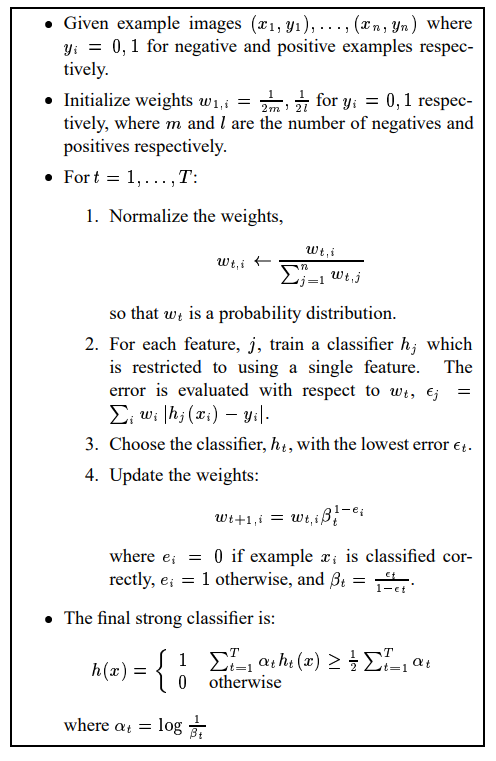

Quanto mais preciso for o previsor, mais
alto será seu peso. Se ele apenas estimar aleatoriamente, então seu peso será próximo
de zero. No entanto, se ele errar com mais frequência (ou seja, com menos acurácia do
que a estimativa aleatória), então seu peso será negativo.

## 1 Questão

In [29]:
import pandas as pd

amostra_1 = pd.Series({'v1': '2000', 'v2': '4', 'classe': 0, 'peso': '0.1'})
amostra_2 = pd.Series({'v1': '3000', 'v2': '3', 'classe': 0, 'peso': '0.4'})
amostra_3 = pd.Series({'v1': '5000', 'v2': '5', 'classe': 1, 'peso': '0.2'})
amostra_4 = pd.Series({'v1': '-1000', 'v2': '-4', 'classe': 1, 'peso': '0.1'})
amostra_5 = pd.Series({'v1': '-2000', 'v2': '0', 'classe': 1, 'peso': '0.2'})

df = pd.DataFrame([amostra_1, amostra_2, amostra_3, amostra_4, amostra_5])
df


,v1,v2,classe,peso
0,2000,4,0,0.1
1,3000,3,0,0.4
2,5000,5,1,0.2
3,-1000,-4,1,0.1
4,-2000,0,1,0.2


In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier
import numpy as np

T = 3 #number of weak learners
show_training_info = True

print(__doc__)

def load_lista1_dataset():
    #from numpy import genfromtxt
    my_data = np.genfromtxt('https://raw.githubusercontent.com/AdrianoMedeirosPinheiro/AdaBoost/main/dataset_treino.txt', delimiter=',')
    X = my_data[:,:2] # two first parameters are input vector #dois primeiros parâmetros são vetor de entrada
    #y = my_data[:,2:]
    y = np.ravel(my_data[:,2:],order='C') #convert column vector into 1D array #converter vetor de coluna em matriz 1D
    return X,y

def load_simple():
    #from numpy import genfromtxt
    my_data = np.genfromtxt('https://raw.githubusercontent.com/AdrianoMedeirosPinheiro/AdaBoost/main/dataset_treino.txt', delimiter=',')
    X = my_data[:,:2] # fish length and weight #comprimento e peso do peixe
    y = np.ravel(my_data[:,2:],order='C') #convert column vector into 1D array #converter vetor de coluna em matriz 1D
    return X,y

def adaboost_predict(x, weak_classifiers, alphas, num_weak_classifiers):
    decision_threshold = 0.5 * np.sum(alphas)
    score = 0
    for t in range(num_weak_classifiers):
        score += alphas[t] * weak_classifiers[t].predict(x)
    return np.array([score >= decision_threshold]).astype(int)

def weighted_error(prediction, correct_label, weights):
    error_indices = np.argwhere(prediction != correct_label)
    return np.sum(weights[error_indices])

if False:
    X, y = load_lista1_dataset()
else:
    X, y = load_simple()

num_training_examples = X.shape[0]

#Initialization of instance weights #Inicialização dos pesos de instância
sample_weight = np.zeros(y.shape, dtype=float)
index_of_positive_classes = np.argwhere(y==1)
index_of_negative_classes = np.argwhere(y==0)
num_positive = len(index_of_positive_classes)
num_negative = len(index_of_negative_classes)

sample_weight[index_of_positive_classes] = 1.0 / (2*num_positive)
sample_weight[index_of_negative_classes] = 1.0 / (2*num_negative)

sample_weight = [0.1 , 0.4, 0.2, 0.1, 0.2]

print('Initial sample_weight', sample_weight)

weak_classifiers = list()
alphas = list()
for t in range(T):
    print("######## Iteration t=",t)

    #1) normalize weight #normalizar o peso
    weights_sum = np.sum(sample_weight)
    sample_weight = sample_weight / weights_sum
    
    

    if show_training_info:
        print('sample_weight=',sample_weight)

    #2) select the best weak classifier with respect to weighthed error #selecionar o melhor classificador fraco em relação ao erro ponderado
    decision_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
    decision_stump.fit(X, y, sample_weight)

    #3) Define the weak classifier h_t(x) #Defina o classificador fraco h_t(x)
    weak_classifiers.append(decision_stump)

    #4) Update the weights based on the decision of the classifier that
    #incorporates all previously designed weak classifiers #Atualize os pesos com base na decisão do classificador que
    #incorporates todos os classificadores fracos previamente projetados
    y_pred = decision_stump.predict(X)

    epsilon_weighted_error = weighted_error(y_pred, y, sample_weight)
    #AK: function below return strange, large values
    #epsilon_weighted_error = decision_stump.score(X, y, sample_weight)

    beta = epsilon_weighted_error / (1.0 - epsilon_weighted_error)
    this_alpha = np.log(1.0/beta)
    alphas.append(this_alpha)

    predictions_of_weak_classifier_t = decision_stump.predict(X)

    errors_i = np.array((predictions_of_weak_classifier_t != y)).astype(int)
    sample_weight *= beta ** (1.0-errors_i)
    #sample_weight = sample_weight / np.sum(sample_weight)
    
    

    if show_training_info:
        print('predictions_of_weak_classifier_t=',predictions_of_weak_classifier_t)
        print('                  correct labels=',y)
        print('epsilon_weighted_error=', epsilon_weighted_error)
        #print('sample_weight=',sample_weight)
        print('beta_t=',beta,'alpha_t=',this_alpha)
        print('errors_i=',errors_i)

for t in range(T):
    print('t=', t, ', alpha_t=',alphas[t])
    r = export_text(weak_classifiers[t]) #, feature_names=feature_names) #, class_names=target_names)
    print(r)
print('threshold =', 0.5 * np.sum(alphas))

predictions_of_strong_classifier = adaboost_predict(X, weak_classifiers, alphas, T)
print('predictions_of_strong_classifier=',predictions_of_strong_classifier)
print('                          labels=',y)

print('\n\n#### Comparison with scikit-learn ####')
ada_discrete = AdaBoostClassifier(
    base_estimator=decision_stump,
    learning_rate=1,
    n_estimators=T,
    algorithm="SAMME")
ada_discrete.fit(X, y)
ada_discrete_pred = ada_discrete.predict(X)
error_indices = np.argwhere(ada_discrete_pred != y)
print('error_indices=',error_indices)
print('Scikit-learn misclassification error rate (%)=',100.0*len(error_indices)/num_training_examples)

print('Scikit-learn AdaBoost classifier:')
weak_learners_list = ada_discrete.estimators_
for t in range(len(weak_learners_list)):
    print('t=',t,'alpha?=',ada_discrete.estimator_weights_[t])
    r = export_text(weak_learners_list[t]) #, feature_names=feature_names) #, class_names=target_names)
    print(r)


Automatically created module for IPython interactive environment
Initial sample_weight [0.1, 0.4, 0.2, 0.1, 0.2]
######## Iteration t= 0
sample_weight= [0.1 0.4 0.2 0.1 0.2]
predictions_of_weak_classifier_t= [0. 0. 0. 1. 1.]
                  correct labels= [0. 0. 1. 1. 1.]
epsilon_weighted_error= 0.2
beta_t= 0.25 alpha_t= 1.3862943611198906
errors_i= [0 0 1 0 0]
######## Iteration t= 1
sample_weight= [0.0625 0.25   0.5    0.0625 0.125 ]
predictions_of_weak_classifier_t= [0. 0. 1. 0. 0.]
                  correct labels= [0. 0. 1. 1. 1.]
epsilon_weighted_error= 0.1875
beta_t= 0.23076923076923078 alpha_t= 1.466337068793427
errors_i= [0 0 0 1 1]
######## Iteration t= 2
sample_weight= [0.03846154 0.15384615 0.30769231 0.16666667 0.33333333]
predictions_of_weak_classifier_t= [1. 1. 1. 1. 1.]
                  correct labels= [0. 0. 1. 1. 1.]
epsilon_weighted_error= 0.19230769230769232
beta_t= 0.2380952380952381 alpha_t= 1.4350845252893227
errors_i= [1 1 0 0 0]
t= 0 , alpha_t= 1.3862943611

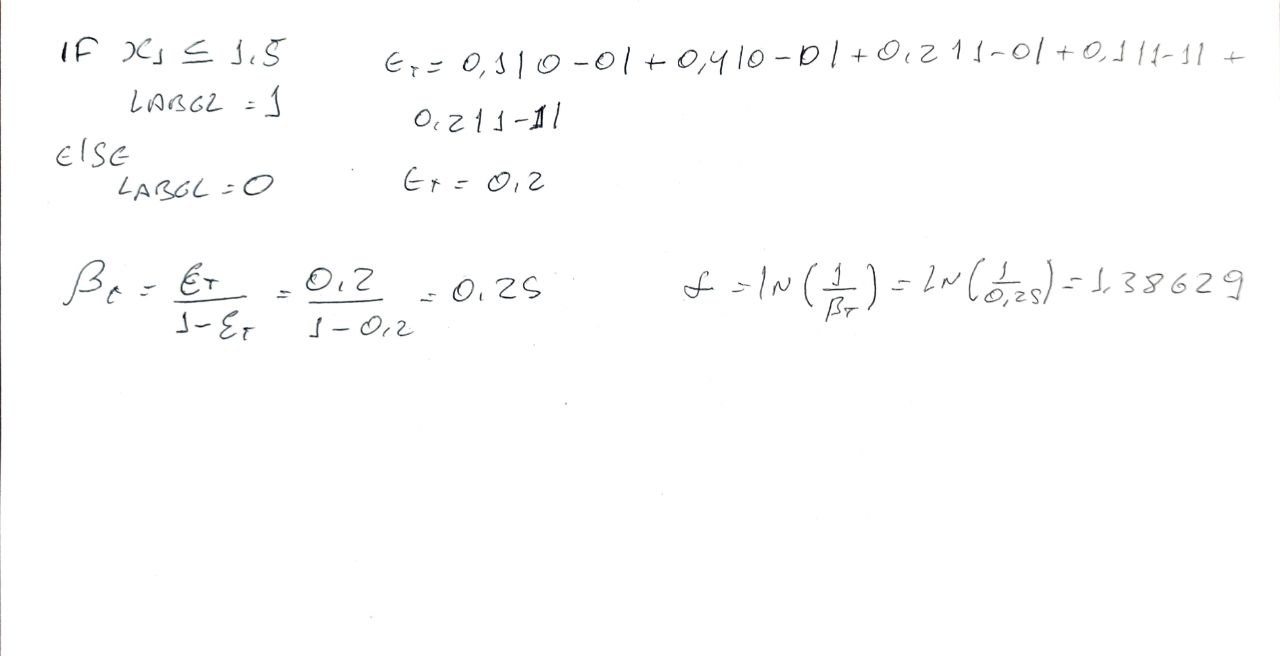

## 2 Questão

### A)

Initial sample_weight [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]

######## Iteration t= 0
sample_weight= [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
predictions_of_weak_classifier_t= [0. 0. 0. 0. 1. 1. 1. 0.]
correct labels= [0. 0. 0. 0. 1. 1. 1. 1.]
epsilon_weighted_error= 0.125
beta_t= 0.14285714285714285 alpha_t= 1.9459101490553132
errors_i= [0 0 0 0 0 0 0 1]

######## Iteration t= 1
sample_weight= [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
0.07142857 0.5 ]
predictions_of_weak_classifier_t= [0. 0. 0. 1. 1. 1. 1. 1.]
correct labels= [0. 0. 0. 0. 1. 1. 1. 1.]
epsilon_weighted_error= 0.07142857142857144
beta_t= 0.07692307692307693 alpha_t= 2.5649493574615367
errors_i= [0 0 0 1 0 0 0 0]

######## Iteration t= 2
sample_weight= [0.03846154 0.03846154 0.03846154 0.5 0.03846154 0.03846154
0.03846154 0.26923077]
predictions_of_weak_classifier_t= [0. 0. 0. 0. 0. 0. 0. 1.]
correct labels= [0. 0. 0. 0. 1. 1. 1. 1.]
epsilon_weighted_error= 0.11538461538461539
beta_t= 0.13043478260869568 alpha_t= 2.0368819272610397
errors_i= [0 0 0 0 1 1 1 0]


t= 0 , alpha_t= 1.9459101490553132
|--- feature_0 <= -3000.00
| |--- class: 1.0
|--- feature_0 > -3000.00
| |--- class: 0.0
t= 1 , alpha_t= 2.5649493574615367
|--- feature_0 <= 0.00
| |--- class: 1.0
|--- feature_0 > 0.00
| |--- class: 0.0
t= 2 , alpha_t= 2.0368819272610397
|--- feature_1 <= 2.00
| |--- class: 0.0
|--- feature_1 > 2.00
| |--- class: 1.0


threshold = 3.2738707168889447
predictions_of_strong_classifier= [[0 0 0 0 1 1 1 1]]
labels= [0. 0. 0. 0. 1. 1. 1. 1.]

## B)

In [30]:
import pandas as pd

amostra_1 = pd.Series({'v1': '0', 'v2': '2', 'classe': 0, 'peso': '0.25'})
amostra_2 = pd.Series({'v1': '3000', 'v2': '-4', 'classe': 0, 'peso': '0.25'})
amostra_3 = pd.Series({'v1': '-1000', 'v2': '0', 'classe': 1, 'peso': '0.25'})
amostra_4 = pd.Series({'v1': '-6000', 'v2': '-2', 'classe': 1, 'peso': '0.25'})


df = pd.DataFrame([amostra_1, amostra_2, amostra_3, amostra_4, amostra_5])
df

,v1,v2,classe,peso
0,0,2,0,0.25
1,3000,-4,0,0.25
2,-1000,0,1,0.25
3,-6000,-2,1,0.25
4,-2000,0,1,0.2


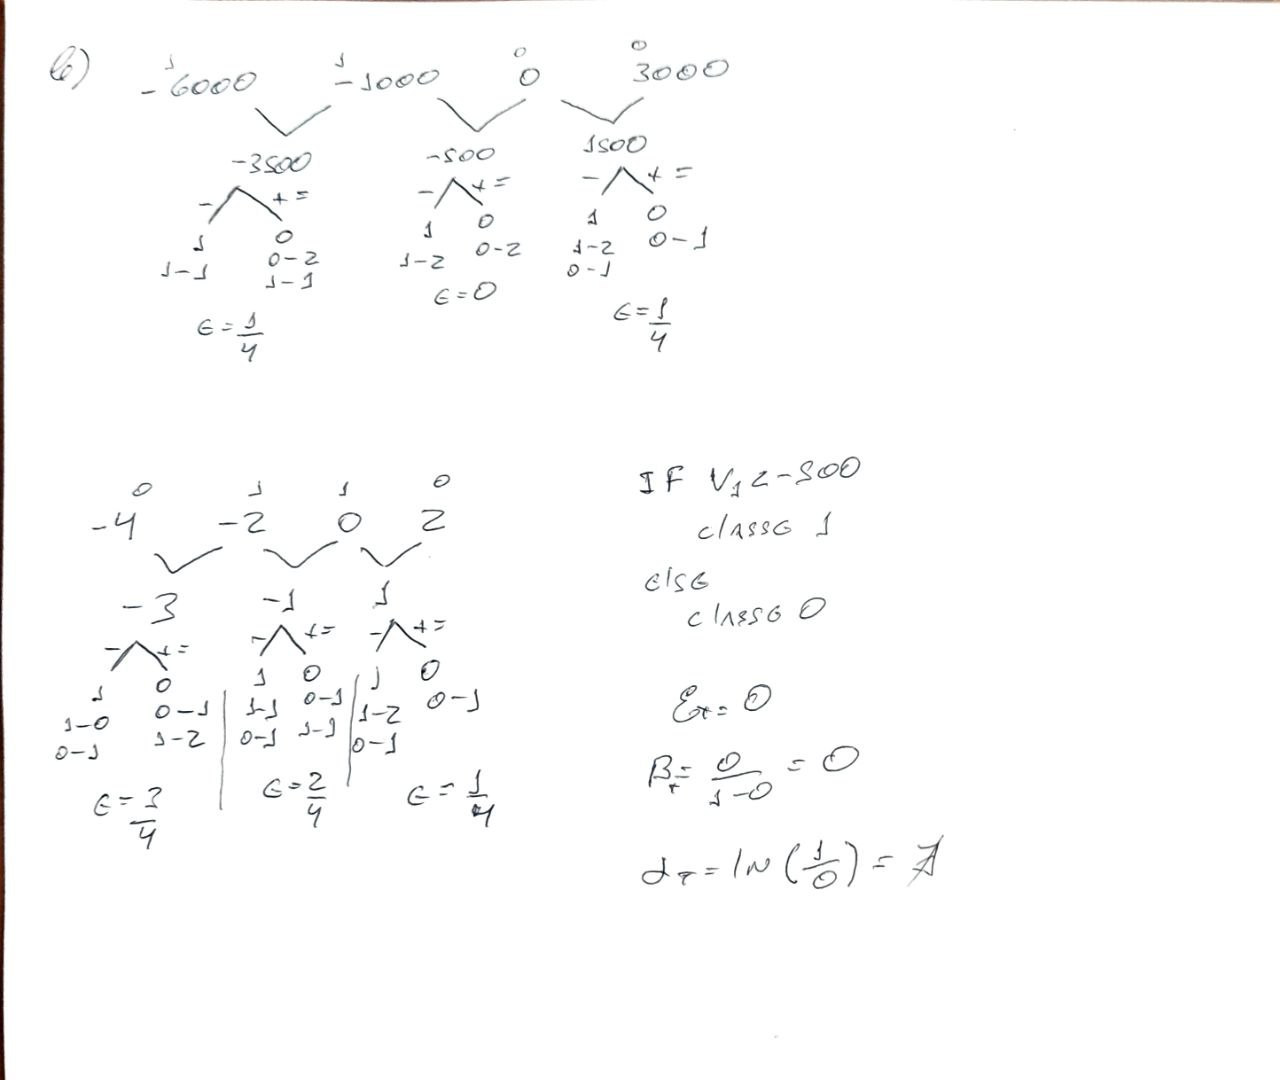